
# Fused Softmax

In this tutorial, you will write a fused softmax operation that is significantly faster
than PyTorch's native op for a particular class of matrices: those whose rows can fit in
the GPU's SRAM.

In doing so, you will learn about:

* The benefits of kernel fusion for bandwidth-bound operations.

* Reduction operators in Triton.


## Motivations

Custom GPU kernels for elementwise additions are educationally valuable but won't get you very far in practice.
Let us consider instead the case of a simple (numerically stabilized) softmax operation:



In [54]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = triton.runtime.driver.active.get_active_torch_device()

def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')


def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret

When implemented naively in PyTorch, computing :code:`y = naive_softmax(x)` for $x \in R^{M \times N}$
requires reading $5MN + 2M$ elements from DRAM and writing back $3MN + 2M$ elements.
This is obviously wasteful; we'd prefer to have a custom "fused" kernel that only reads
X once and does all the necessary computations on-chip.
Doing so would require reading and writing back only $MN$ bytes, so we could
expect a theoretical speed-up of ~4x (i.e., $(8MN + 4M) / 2MN$).
The `torch.jit.script` flags aims to perform this kind of "kernel fusion" automatically
but, as we will see later, it is still far from ideal.



## Compute Kernel

Our softmax kernel works as follows: each program loads a set of rows of the input matrix X strided by number of programs,
normalizes it and writes back the result to the output Y.

Note that one important limitation of Triton is that each block must have a
power-of-two number of elements, so we need to internally "pad" each row and guard the
memory operations properly if we want to handle any possible input shapes:



In [55]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
    # starting row of the program
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # The stride represents how much we need to increase the pointer to advance 1 row
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # The block size is the next power of two greater than n_cols, so we can fit each
        # row in a single block
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        # Subtract maximum for numerical stability
        row_minus_max = row - tl.max(row, axis=0)
        # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator
        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

We can create a helper function that enqueues the kernel and its (meta-)arguments for any given input tensor.



In [56]:
import triton
print(triton.__version__)

3.3.1


In [57]:
driver.active.utils.get_device_properties(DEVICE.index)

{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 68,
 'warpSize': 32,
 'sm_clock_rate': 1710000,
 'mem_clock_rate': 9501000,
 'mem_bus_width': 320}

In [64]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}


def softmax(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 8

    # Number of software pipelining stages.
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    if is_hip():
        # NUM_REGS represents the number of regular purpose registers. On CDNA architectures this is half of all registers available.
        # However, this is not always the case. In most cases all registers can be used as regular purpose registers.
        # ISA SECTION (3.6.4 for CDNA3)
        # VGPRs are allocated out of two pools: regular VGPRs and accumulation VGPRs. Accumulation VGPRs are used
        # with matrix VALU instructions, and can also be loaded directly from memory. A wave may have up to 512 total
        # VGPRs, 256 of each type. When a wave has fewer than 512 total VGPRs, the number of each type is flexible - it is
        # not required to be equal numbers of both types.
        NUM_GPRS = NUM_REGS
        if is_cdna():
            NUM_GPRS = NUM_REGS * 2

        # MAX_NUM_THREADS represents maximum number of resident threads per multi-processor.
        # When we divide this number with WARP_SIZE we get maximum number of waves that can
        # execute on a CU (multi-processor)  in parallel.
        MAX_NUM_THREADS = properties["max_threads_per_sm"]
        max_num_waves = MAX_NUM_THREADS // WARP_SIZE
        occupancy = min(NUM_GPRS // WARP_SIZE // n_regs, max_num_waves) // num_warps
    else:
        occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy

    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE, num_stages)
    return y

## Unit Test



We make sure that we test our kernel on a matrix with an irregular number of rows and columns.
This will allow us to verify that our padding mechanism works.



In [65]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

24


As expected, the results are identical.



## Benchmark

Here we will benchmark our operation as a function of the number of columns in the input matrix -- assuming 4096 rows.
We will then compare its performance against (1) :code:`torch.softmax` and (2) the :code:`naive_softmax` defined above.



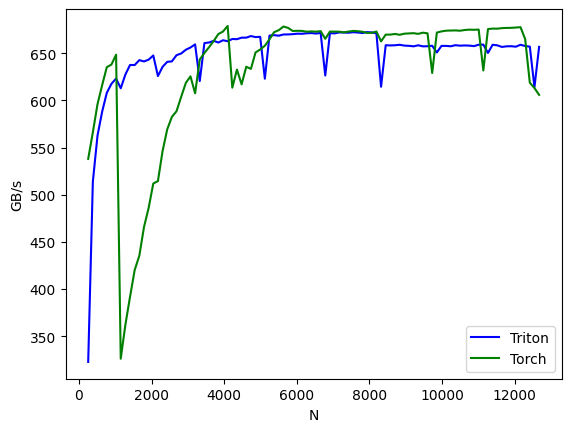

softmax-performance:
          N      Triton       Torch
0     256.0  322.807218  538.034045
1     384.0  513.822451  566.197022
2     512.0  562.625963  595.942277
3     640.0  588.058839  616.136022
4     768.0  607.990568  635.265166
5     896.0  617.617910  637.985793
6    1024.0  623.144246  648.493910
7    1152.0  612.840469  326.204435
8    1280.0  627.456165  362.192109
9    1408.0  637.545451  391.875861
10   1536.0  637.508813  420.230279
11   1664.0  642.694349  435.411196
12   1792.0  641.293089  465.706738
13   1920.0  643.217731  485.996362
14   2048.0  647.618225  511.893332
15   2176.0  625.803068  514.489883
16   2304.0  635.608970  546.317230
17   2432.0  640.858057  569.324407
18   2560.0  641.372093  582.507344
19   2688.0  647.934578  588.532697
20   2816.0  649.730428  603.779459
21   2944.0  653.693931  618.539350
22   3072.0  656.098099  625.518930
23   3200.0  659.366713  607.489793
24   3328.0  620.528073  643.380001
25   3456.0  660.784281  650.230535
26   35

In [12]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)

In the above plot, we can see that:
 - Triton is 4x faster than the Torch JIT. This confirms our suspicions that the Torch JIT does not do any fusion here.
 - Triton is noticeably faster than :code:`torch.softmax` -- in addition to being **easier to read, understand and maintain**.
   Note however that the PyTorch `softmax` operation is more general and will work on tensors of any shape.



# Reproduce

This is for comparing between Pytorch Naive version of softmax and Triton version of softmax

## Get System Information

In [93]:
import torch
import triton
import triton.language as tl
from triton.runtime import driver

In [94]:
DEVICE = triton.runtime.driver.active.get_active_torch_device()
print(DEVICE)

cuda:0


In [95]:
# For AMD GPU
def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')

In [96]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)

In [97]:
x.max(dim=1)

torch.return_types.max(
values=tensor([3.3156, 2.7486, 3.1057,  ..., 2.8307, 3.4152, 3.2924], device='cuda:0'),
indices=tensor([254, 447,  15,  ..., 767, 468, 117], device='cuda:0'))

In [98]:
x.shape

torch.Size([1823, 781])

## Naive version of computing all elements then do division

In [99]:
def naive_softmax(x):
    x_max = x.max(dim=1)[0] # [0] get the value only, [1] get the index
    z = x - x_max[:, None] # [:, None] add a new dimension at the end match the 2D shape of x
    numerator = torch.exp(z)
    denominator = numerator.sum(dim=1) # dim = 1 means sum along the second dimension
    ret = numerator / denominator[:, None]
    return ret

In [100]:
naive_softmax(x)

tensor([[3.2747e-04, 5.3954e-04, 5.8687e-05,  ..., 5.5490e-04, 2.0330e-04,
         9.4091e-04],
        [8.6914e-04, 1.1075e-03, 1.0202e-04,  ..., 1.1470e-04, 5.5436e-04,
         8.6046e-04],
        [1.4101e-03, 1.0511e-03, 1.7031e-03,  ..., 1.2272e-03, 7.9059e-04,
         3.2380e-04],
        ...,
        [9.1390e-05, 1.8119e-03, 7.3820e-04,  ..., 4.9138e-04, 1.0970e-03,
         3.0001e-04],
        [6.0799e-04, 3.1319e-04, 3.9022e-04,  ..., 1.7920e-03, 5.4649e-04,
         5.0780e-04],
        [4.8949e-04, 2.2639e-03, 7.8792e-04,  ..., 6.6472e-04, 1.9889e-03,
         3.5868e-04]], device='cuda:0')

## Triton Version

### Kernel Function

In [101]:
# @triton.jit is the decorator to indicate that the function is a Triton kernel function
@triton.jit
def softmax_kernel(
    output_ptr, 
    input_ptr,
    input_row_stride,
    output_row_stride,
    n_rows,
    n_cols,
    BLOCK_SIZE: tl.constexpr,  # By scalar here we mean a numeric literal, a variable marked with tl.constexpr 
    num_stages: tl.constexpr,
):
    # Find the starting point
    row_start = tl.program_id(0) # Returns the id of the current program instance along the given axis.
    row_step = tl.num_programs(0) # Returns the number of program instances launched along the given axis.
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # ================================== num_stages ==================================
        # On A100 GPUs, the Triton compiler uses asynchronous copy instructions (cp.async)
        # to pipeline loop iterations and hide global memory latency. The 'num_stages'
        # parameter controls the depth of this pipeline. That is, how many iterations of the loop
        # are processed concurrently in different stages.
        #
        # For example, with num_stages = 3:
        #   Iteration 0 starts loading data from global memory into shared memory.
        #   Iteration 1 begins computing using data prefetched by iteration 0.
        #   Iteration 2 might start storing results while the next iteration starts loading.
        #
        # This overlapping of [load] to [compute] to [store] across different loop iterations improves
        # performance by keeping the GPU busy.
        #
        # However, because each streaming iteration needs its own buffer in shared memory to store
        # prefetched data, the shared memory usage increases linearly with 'num_stages'.

        # Calculate the initial pointer address using stride and row_idx
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # BLOCK_SIZE is always a power of two
        # Triton takes one calculation step as a whole block, so we need to calculate the whole block at a time
        col_offsets = tl.arange(0, BLOCK_SIZE)  # Create a vector from 0 to BLOCK_SIZE
        # Get all the starting pointer addresses for a whole block calculation
        input_ptrs = row_start_ptr + col_offsets
        # Foolproofing against going outside of the address limit. Since BLOCK_SIZE is always the ceiling to a power of 2,
        # it can be larger than needed.
        # We solve this issue by using a mask
        mask = col_offsets < n_cols
        # Get the data
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        # tl.load() returns a tensor of data whose values are loaded from memory at locations defined by the pointer
        # other (Block, optional) – if mask[idx] is false, return other[idx]
        
        # Calculation
        row_minus_max = row - tl.max(row, axis=0)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator

        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

In [102]:
import numpy as np
np.arange(0,12) < 6

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False])

### Host Function

#### Get System Info

In [103]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
print(properties)

{'max_shared_mem': 101376, 'max_num_regs': 65536, 'multiprocessor_count': 68, 'warpSize': 32, 'sm_clock_rate': 1710000, 'mem_clock_rate': 9501000, 'mem_bus_width': 320}


In [104]:
triton.runtime.driver.active.get_current_target()

GPUTarget(backend='cuda', arch=86, warp_size=32)

In [105]:
# GPU hardware properties retrieved from Triton backend
# These are useful for kernel performance tuning and resource allocation.

NUM_SM = properties["multiprocessor_count"]
# Number of Streaming Multiprocessors (SMs) on the GPU.
# Each SM can run multiple warps in parallel.

NUM_REGS = properties["max_num_regs"]
# Maximum number of 32-bit registers available per thread block.
# Register pressure can limit kernel occupancy.

SIZE_SMEM = properties["max_shared_mem"]
# Total shared memory (in bytes) available per block.
# Shared memory is on-chip and much faster than global memory.

WARP_SIZE = properties["warpSize"]
# Number of threads in a warp (typically 32).
# All threads in a warp execute in lockstep.

target = triton.runtime.driver.active.get_current_target()
# Gets the active Triton compilation target (e.g., CUDA backend and architecture).

kernels = {}
# Dictionary to hold compiled or cached Triton kernels.

In [106]:
def softmax_triton(x):
    n_rows, n_cols = x.shape

    # Get BLOCK_SIZE as the next number from power of 2 on n_cols
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    num_warps = 8

    num_stages = 4 if SIZE_SMEM > 200000 else 2

    y = torch.empty_like(x)

    # Pre-compile kernel to get register usage and compute thread occupancy
    # softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr, 
    # num_stages: tl.constexpr)

    # Stride is the jump (in memory) necessary to go from one element to the next
    # in the specified dimension `dim`. It is typically expressed in units of elements,
    # not bytes.
    #
    # - If no argument is passed, a tuple of all strides (for each dimension) is returned.
    # - If a specific dimension `dim` is provided, an integer value is returned representing
    #   the stride along that particular dimension.
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, 
                                   BLOCK_SIZE = BLOCK_SIZE, num_stages=num_stages,
                                   num_warps=num_warps, grid=(1,))
    # grid=(1,) specifies that only one Triton program instance (along axis 0) should be launched.
    # This is typically used during warmup to compile the kernel without executing a full workload.
    # It helps ensure the kernel is JIT-compiled and cached before actual execution.

    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared

    # For CUDA
    occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy
    num_programs = min(num_programs, n_rows)

    # Lanuch Kernel
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE, num_stages)
    return y


## TEST

In [107]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = softmax_triton(x)
y_torch = torch.softmax(x, axis = 1)
y_naive_softmax = naive_softmax(x)

assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)
assert torch.allclose(y_triton, y_torch), "Triton and Torch mismatch"
assert torch.allclose(y_triton, y_naive_softmax), "Triton and Naive mismatch"
assert torch.allclose(y_torch, y_naive_softmax), "Torch and Naive mismatch"

## Benchmark

In [116]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals = [128* i for i in range(2, 100)], 
        line_arg = 'provider',
        line_vals = ['triton', 'torch'],
        line_names = [
            "Triton",
            "Torch",
        ],
        styles = [
            ('blue', '-'),
            ('green', '-'),
        ],
        ylabel = "GB/s",
        plot_name = "softmax-performance",
        args = {'M':4096}
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis = -1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax_triton(x))
    
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


In [115]:
import importlib
import triton
importlib.reload(triton)


<module 'triton' from '/home/eeepc/Documents/test2/CS336_assignment2-systems/.venv/lib/python3.11/site-packages/triton/__init__.py'>

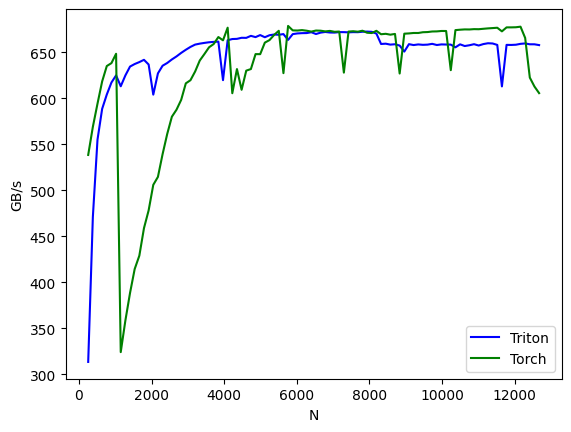

softmax-performance:
          N      Triton       Torch
0     256.0  313.266252  538.270423
1     384.0  470.678707  568.734731
2     512.0  554.854201  593.992679
3     640.0  588.348534  618.154653
4     768.0  603.920286  634.899230
5     896.0  617.002792  638.079004
6    1024.0  624.741974  648.243130
7    1152.0  612.912143  323.914663
8    1280.0  624.725075  358.307370
9    1408.0  634.339753  388.259209
10   1536.0  637.084677  414.260756
11   1664.0  639.197380  428.744035
12   1792.0  641.659182  458.709346
13   1920.0  636.579877  477.986122
14   2048.0  603.812902  505.761456
15   2176.0  626.920126  514.407655
16   2304.0  635.232135  539.055535
17   2432.0  638.223700  561.108469
18   2560.0  642.063921  579.817713
19   2688.0  645.376742  587.468624
20   2816.0  649.184536  598.119338
21   2944.0  652.588757  616.082603
22   3072.0  655.692463  619.505299
23   3200.0  658.205427  628.931283
24   3328.0  659.250400  640.900009
25   3456.0  660.061645  647.956746
26   35

In [117]:
benchmark.run(show_plots=True, print_data=True)